# Báo cáo Project Khoa học Dữ liệu (2023–2025 → Dự báo 2026)

**Chủ đề:** Phân tích điểm thi THPT 2023–2025, điểm gãy 2025, và dự báo 2026  
**Hình thức nộp:** *Notebook báo cáo có code + đồ thị (theo yêu cầu giảng viên)*

> **Lưu ý:** Notebook này bám đúng pipeline trong project (bỏ qua dashboard).  
> Các khối **TODO (SSR/ảnh minh hoạ)** được chừa để chèn hình chụp màn hình/biểu đồ bổ sung khi hoàn thiện báo cáo.


## Mục lục
1. Giới thiệu
2. Tổng quan dữ liệu
3. Pipeline dự án (Raw → Clean → EDA/Stats → ChangePoint → Forecast)
4. EDA & Thống kê mô tả  
   4.1 Theo môn (Toán, Văn, Lí, Sử, Anh)  
   4.2 Theo khối (A00, A01, C00, D01)  
   4.3 Theo tỉnh (TP.HCM, Hà Nội, Đà Nẵng, Cà Mau)
5. Kiểm định ANOVA và t-test
6. Phân tích điểm gãy 2025 (Change Point)
7. Dự báo 2026
8. Kết luận, hạn chế và hướng phát triển


In [15]:
# ==== Cell 1: Setup path + import modules/models ====
from __future__ import annotations
import sys
from pathlib import Path

def find_project_root(start: Path) -> Path:
    '''
    Tìm PROJECT_ROOT bằng cách đi ngược lên cho đến khi thấy các thư mục cốt lõi:
    Module/, Model/ (Clean_Data_2023-2025 có thể đã/ chưa được tạo)
    '''
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "Module").exists() and (p / "Model").exists():
            return p
    raise FileNotFoundError(
        "Không tìm thấy PROJECT_ROOT (cần có Module/ và Model/). "
        "Hãy mở notebook trong repo project."
    )

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)

# Add root to sys.path để import Module.*, Model.*
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Imports: Module
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis
from Module.Export import Export
from Module.ANOVA_ttest import ANOVA_ttest

# Imports: Model
from Model.ChangePointPreparer import ChangePointPreparer
from Model.ChangePointAnalyzer import ChangePointAnalyzer
from Model.ChangePointDetector import ChangePointDetector

from Model.ForecastSubjectModel import ForecastModel, build_ml_df
from Model.ForecastBlockModel import ForecastBlockModel

# Plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


NOTEBOOK_DIR: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Report
PROJECT_ROOT: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


### (Tiện ích) Hàm hỗ trợ xem code

Cell dưới đây tạo 2 hàm:
- `show_object(ClassOrFunc)` để in source code của class/hàm đã import
- `show_file("Module/xxx.py", start=.., end=..)` để in theo dòng từ file


In [16]:
# ==== Cell X: Helper to show module/model code in-report ====
import inspect
from pathlib import Path

def show_file(rel_path: str, start: int = 1, end: int = 200, encoding: str = "utf-8"):
    """Print a slice of a .py file (by line numbers)."""
    p = Path(PROJECT_ROOT) / rel_path
    if not p.exists():
        print(f"[!] File not found: {p}")
        return
    lines = p.read_text(encoding=encoding, errors="ignore").splitlines()
    start = max(1, start)
    end = min(len(lines), end)
    print(f"--- {rel_path} (lines {start}-{end} / {len(lines)}) ---")
    for i in range(start-1, end):
        print(f"{i+1:>4}: {lines[i]}")
    print("--- end ---")

def show_object(obj, max_lines: int = 220):
    """Print source code of a class/function (clipped)."""
    try:
        src = inspect.getsource(obj).splitlines()
    except Exception as e:
        print(f"[!] Cannot get source for {obj}: {e}")
        return
    n = len(src)
    clip = src[:max_lines]
    print(f"--- source: {getattr(obj, '__name__', str(obj))} (showing {len(clip)}/{n} lines) ---")
    print("\n".join(clip))
    if n > max_lines:
        print(f"... (clipped {n-max_lines} lines) ...")
    print("--- end ---")


## 1. Giới thiệu
Mục tiêu của project:
- Chuẩn hoá và phân tích dữ liệu điểm thi THPT giai đoạn **2023–2025**.
- Định lượng sự thay đổi lớn năm **2025** (điểm gãy) bằng Change Point.
- Dự báo **2026** theo:
  - **Điểm trung bình theo môn**
  - **Tỉ lệ lựa chọn tổ hợp/khối**

## 2. Tổng quan dữ liệu
Dữ liệu sử dụng gồm các năm 2023–2025 (raw), trong đó năm 2025 có các cấu trúc/nguồn khác nhau (**CT2006** và **CT2018**) nên cần bước chuẩn hoá trước khi phân tích.

**TODO (SSR/ảnh minh hoạ):**
- [ ] Ảnh cấu trúc thư mục dữ liệu raw
- [ ] Ảnh ví dụ một file dữ liệu 2023/2024 (CSV) và 2025 (XLSX)


## 3. Pipeline dự án (bỏ qua dashboard)

Pipeline chuẩn trong repo:

1) **Load raw** (`Module/Load_Data.py`)  
2) **Process/Normalize** (`Module/Processor_Data.py`)  
3) **Analyze** theo 3 góc nhìn: môn / khối / tỉnh (`Module/Analysis.py`)  
4) **Export clean** ra `Clean_Data_2023-2025/` (`Module/Export.py`)  
5) Notebook làm việc trên clean-data:
   - **EDA + kiểm định** (`Notebook/EDA.ipynb`)
   - **Change Point** (`Notebook/ChangePoint.ipynb`)
   - **Forecast 2026** (`Notebook/Forecast2026.ipynb`)

Trong notebook Report này, ta chạy theo đúng pipeline trên nhưng chỉ chọn **một tập đại diện** (theo yêu cầu) để minh hoạ EDA và phân tích.

**TODO (SSR/ảnh minh hoạ):**
- [ ] SSR pipeline/flowchart (nếu có)


### 3.1 Tham chiếu code (để thầy xem ngay trong Report)

Các cell dưới đây **in trực tiếp source code** của những module/model chính (đã import ở Cell 1).  
Mục tiêu: khi thầy hỏi “phần này nằm ở đâu / xử lý thế nào”, bạn mở đúng cell này và giải thích được.

> Gợi ý dùng khi báo cáo: chỉ cần mở đúng class/hàm liên quan, không cần show cả file.


In [31]:
# ==== Cell 3.1: Code references — Data pipeline modules ====
show_object(DataLoader)
show_object(CleanDataLoader)
show_object(DataProcessor)
show_object(Export)
# (tuỳ chọn) show_object(Analysis)


--- source: DataLoader (showing 151/151 lines) ---
class DataLoader:
    """Quản lý việc load dữ liệu THPT RAW từ thư mục project.

    Attributes (public API)
    -----------------------
    project_root : Path
        Thư mục gốc của project. Có thể gán lại sau khi khởi tạo.

    Read-only properties (tính động từ project_root)
    ------------------------------------------------
    thpt2023_ct2006_csv_path : Path
        Đường dẫn tới file CSV điểm thi 2023 (CT2006).
    thpt2024_ct2006_csv_path : Path
        Đường dẫn tới file CSV điểm thi 2024 (CT2006).
    thpt2025_ct2006_xlsx_path : Path
        Đường dẫn tới file XLSX điểm thi 2025 (CT2006).
    thpt2025_ct2018_xlsx_path : Path
        Đường dẫn tới file XLSX điểm thi 2025 (CT2018).
    """

    # Slots: Cố định các thuộc tính có thể sử dụng, để tiết kiệm bộ nhớ.
    # Không thể thêm thuộc tính mới ngoài danh sách này.
    __slots__ = (
        "_project_root",                        # thư mục gốc của project
        "_datase

In [18]:
# ==== Cell 2: (Tuỳ chọn) Chạy pipeline tạo Clean_Data_2023-2025 ====
# Nếu Clean_Data_2023-2025 đã có sẵn thì có thể bỏ qua cell này.
# Đổi RUN_PIPELINE=True nếu cần chạy lại toàn bộ (có thể mất thời gian).

import subprocess

RUN_PIPELINE = False

clean_root = PROJECT_ROOT / "Clean_Data_2023-2025"
if clean_root.exists():
    print("✅ Đã có clean data:", clean_root)
else:
    print("⚠️ Chưa có clean data:", clean_root)

if RUN_PIPELINE:
    cmd = [sys.executable, str(PROJECT_ROOT / "run_pipeline.py")]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)
    print("✅ Done. Clean data at:", clean_root)


✅ Đã có clean data: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Clean_Data_2023-2025


## 4. EDA & Thống kê mô tả

Trong phần EDA của báo cáo, ta chọn các nhóm đại diện theo yêu cầu:

- **Môn:** Toán, Văn, Lí, Sử, Anh  
- **Khối:** A00, A01, C00, D01  
- **Tỉnh:** TP.HCM, Hà Nội, Đà Nẵng, Cà Mau

Mục tiêu EDA:
- Quan sát phân phối điểm theo từng năm.
- So sánh sự thay đổi giữa các năm, đặc biệt quanh mốc 2025.
- Tạo các đồ thị “đủ dùng cho báo cáo” (histogram/boxplot/trend).


In [19]:
# ==== Cell 3: Helper load clean CSV + plotting utilities ====
import unicodedata
from typing import List

def normalize_name(name: str) -> str:
    """Chuẩn hoá tên giống Export._normalize_name (bỏ dấu + bỏ ký tự đặc biệt)."""
    normalized = unicodedata.normalize("NFD", name)
    without_accents = "".join(ch for ch in normalized if unicodedata.category(ch) != "Mn")
    cleaned = "".join(ch for ch in without_accents if ch.isalnum() or ch == "_")
    return cleaned

def list_entities(domain_dir: Path) -> List[str]:
    """List entity names từ các thư mục CleanData_<name>/ trong domain."""
    if not domain_dir.exists():
        return []
    out = []
    for p in domain_dir.iterdir():
        if p.is_dir() and p.name.startswith("CleanData_"):
            out.append(p.name.replace("CleanData_", ""))
    return sorted(out)

def load_clean_csv(domain: str, entity: str, kind: str) -> pd.DataFrame:
    """
    domain: 'Subject_Data' | 'Block_Data' | 'Province_Data'
    entity: folder name sau CleanData_
    kind: 'analysis' | 'distribution'
    """
    domain_dir = clean_root / domain / f"CleanData_{entity}"
    fp = domain_dir / (f"Export_Analysis_{entity}.csv" if kind == "analysis" else f"Export_Distribution_{entity}.csv")
    if not fp.exists():
        raise FileNotFoundError(f"Không tìm thấy file: {fp}")
    return pd.read_csv(fp)

# Selected entities (theo yêu cầu)
subject_entities = ["toan", "ngu_van", "vat_li", "lich_su", "ngoai_ngu"]
subject_labels = {"toan":"Toán","ngu_van":"Văn","vat_li":"Lí","lich_su":"Sử","ngoai_ngu":"Anh"}

block_entities = ["A00", "A01", "C00", "D01"]

province_entities = ["ThanhPhoHoChiMinh", "HaNoi", "DaNang", "CaMau"]
province_labels = {"ThanhPhoHoChiMinh":"TP.HCM","HaNoi":"Hà Nội","DaNang":"Đà Nẵng","CaMau":"Cà Mau"}

def plot_weighted_hist(scores: np.ndarray, weights: np.ndarray, title: str, xlabel: str):
    plt.figure(figsize=(8,4))
    bins = np.arange(-0.5, 10.6, 0.5)
    plt.hist(scores, bins=bins, weights=weights, alpha=0.85, edgecolor="white")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Số học sinh (weighted)")
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_box_by_year(df: pd.DataFrame, score_col: str, year_col: str, title: str):
    plt.figure(figsize=(8,4))
    years = sorted(df[year_col].unique())
    data = [df.loc[df[year_col]==y, score_col].values for y in years]
    plt.boxplot(data, labels=years, showfliers=False)
    plt.title(title)
    plt.xlabel("Năm")
    plt.ylabel(score_col)
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_trend_mean(df_analysis: pd.DataFrame, year_col: str, mean_col: str, title: str):
    plt.figure(figsize=(7,4))
    dfp = df_analysis.sort_values(year_col)
    plt.plot(dfp[year_col], dfp[mean_col], marker="o")
    plt.title(title)
    plt.xlabel("Năm")
    plt.ylabel(mean_col)
    plt.grid(True, alpha=0.2)
    plt.show()



SUBJECT: Toán (toan)


,nam_hoc,mean,median,mode,std,min,max
0,2023,6.250557,6.6,7.60,1.633336,0.0,10.0
1,2024,6.447309,6.8,7.60,1.556900,0.0,9.8
2,2025,4.799712,4.6,4.75,1.688549,0.0,10.0


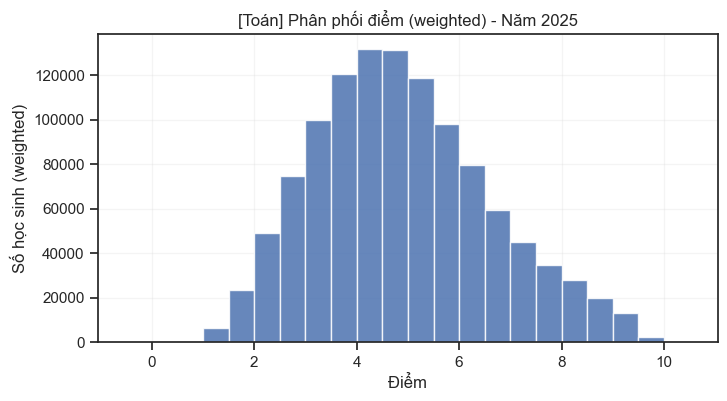

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


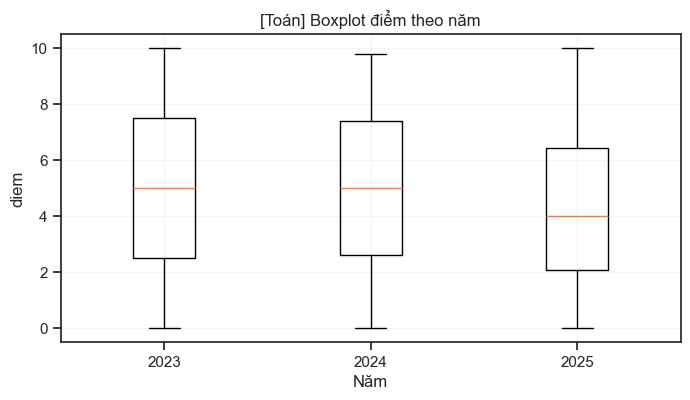

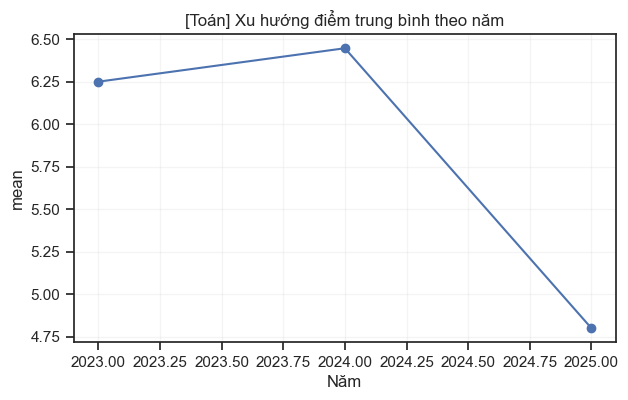


SUBJECT: Văn (ngu_van)


,nam_hoc,mean,median,mode,std,min,max
0,2023,6.858194,7.00,7.0,1.326471,0.0,10.00
1,2024,7.231146,7.50,8.0,1.330057,0.0,10.00
2,2025,6.990479,7.25,7.5,1.291049,0.0,9.75


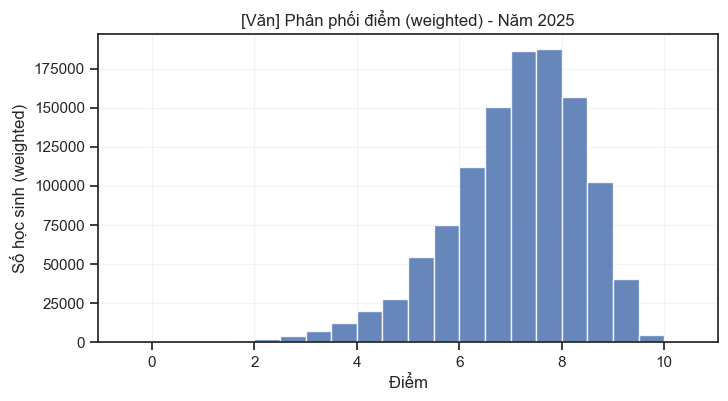

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


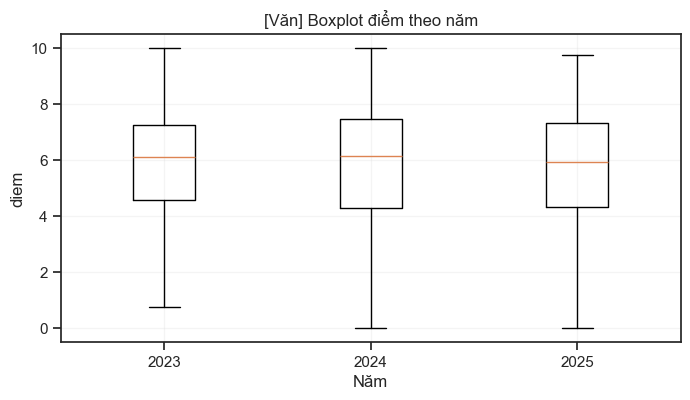

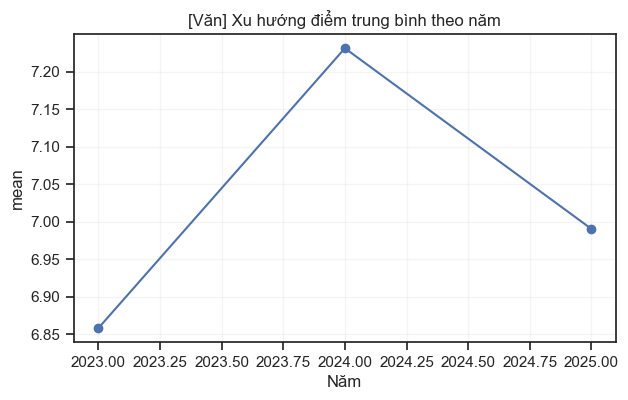


SUBJECT: Lí (vat_li)


,nam_hoc,mean,median,mode,std,min,max
0,2023,6.573900,6.75,7.5,1.486819,0.0,10.0
1,2024,6.666866,7.00,8.0,1.631129,0.0,10.0
2,2025,6.978461,7.00,7.5,1.521617,0.0,10.0


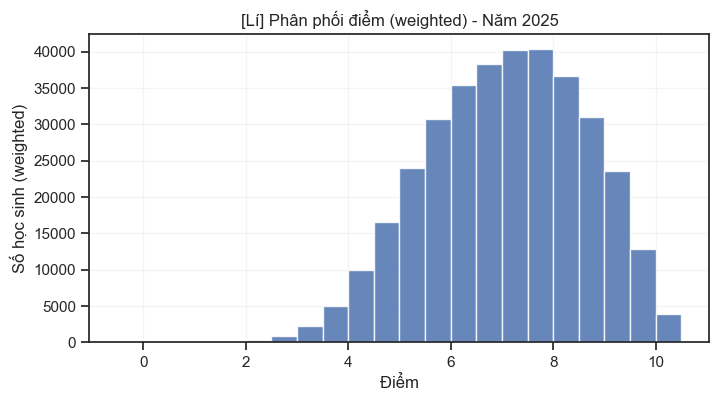

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


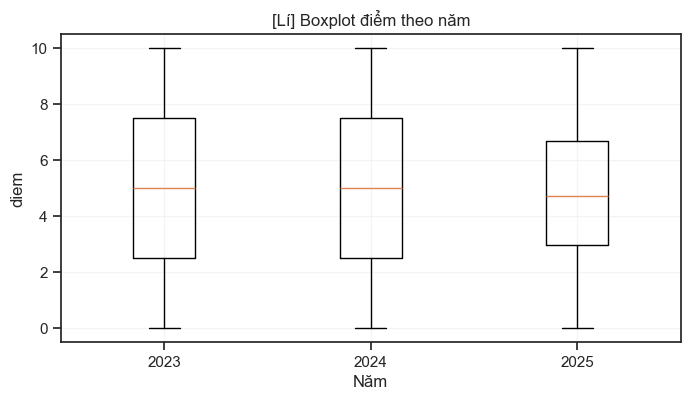

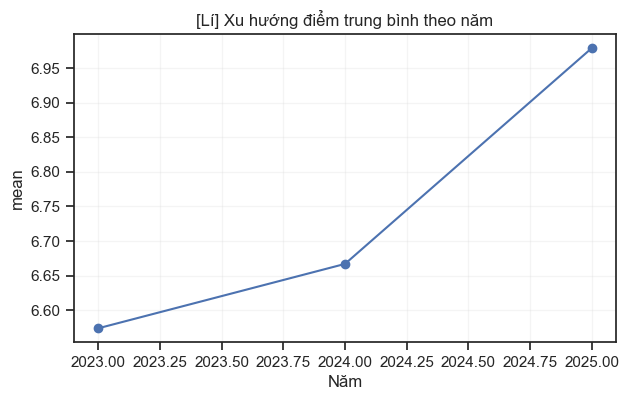


SUBJECT: Sử (lich_su)


,nam_hoc,mean,median,mode,std,min,max
0,2023,6.025629,6.0,5.75,1.552931,0.0,10.0
1,2024,6.570343,6.5,6.75,1.462804,0.0,10.0
2,2025,6.514921,6.5,7.25,1.644317,0.0,10.0


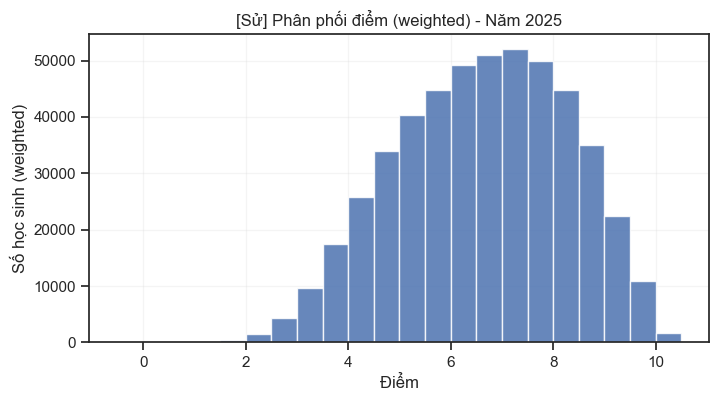

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


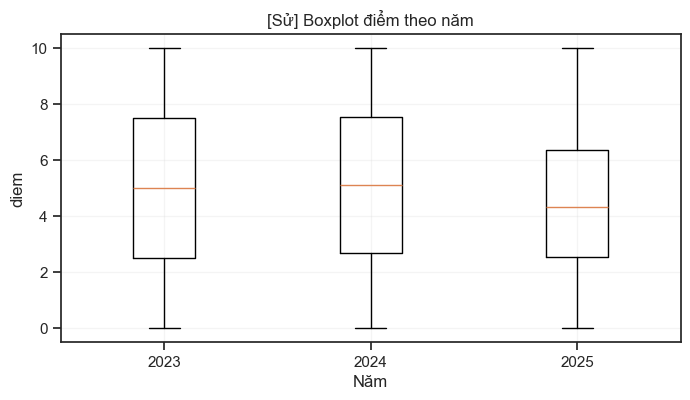

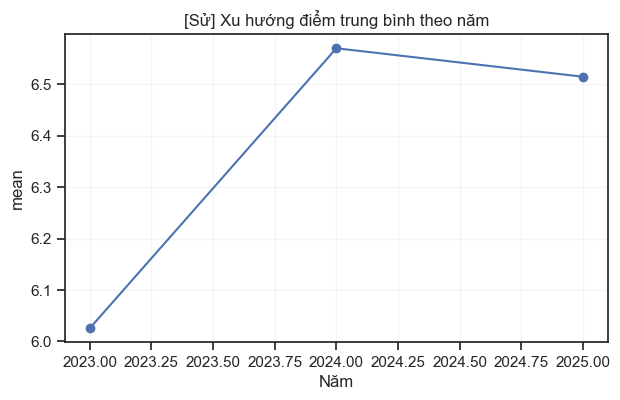


SUBJECT: Anh (ngoai_ngu)


,nam_hoc,mean,median,mode,std,min,max
0,2023,5.462410,5.20,4.20,1.966353,0.0,10.0
1,2024,5.521938,5.20,4.60,1.880657,0.0,10.0
2,2025,5.406338,5.25,5.25,1.487624,0.0,10.0


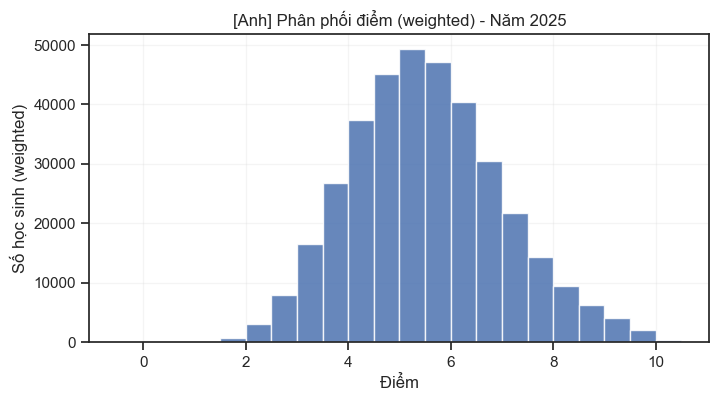

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


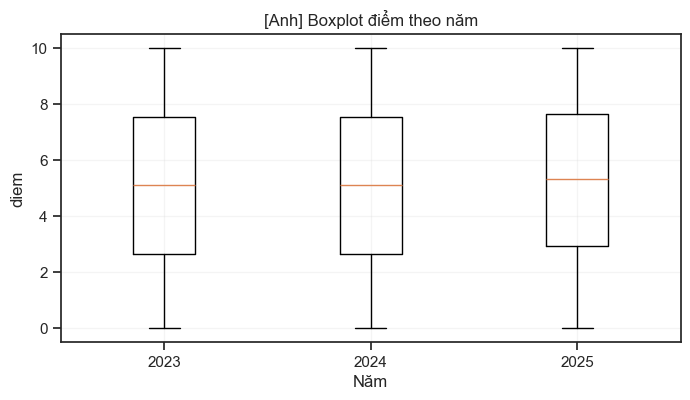

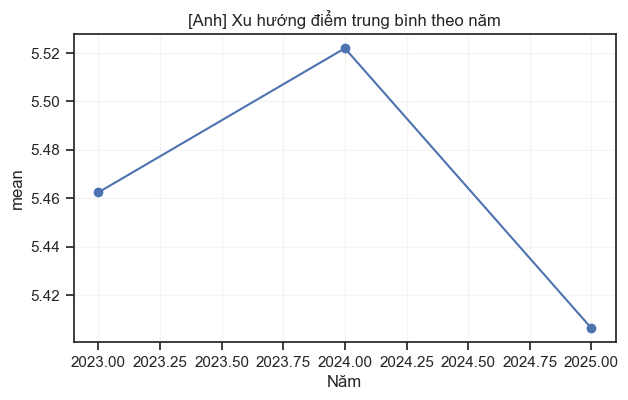

In [20]:
# ==== Cell 4: EDA theo MÔN (Toán, Văn, Lí, Sử, Anh) ====
for subj in subject_entities:
    try:
        dist = load_clean_csv("Subject_Data", subj, "distribution")
        ana = load_clean_csv("Subject_Data", subj, "analysis")
    except FileNotFoundError as e:
        print(f"⚠️ Skip {subj}:", e)
        continue

    label = subject_labels.get(subj, subj)
    print("\n" + "="*80)
    print(f"SUBJECT: {label} ({subj})")
    display(ana)

    year_pick = int(sorted(dist["nam_hoc"].unique())[-1])
    dfy = dist[dist["nam_hoc"] == year_pick]
    plot_weighted_hist(dfy["diem"].to_numpy(), dfy["so_hoc_sinh"].to_numpy(),
                      title=f"[{label}] Phân phối điểm (weighted) - Năm {year_pick}", xlabel="Điểm")

    plot_box_by_year(dist, score_col="diem", year_col="nam_hoc", title=f"[{label}] Boxplot điểm theo năm")

    if "mean" in ana.columns:
        plot_trend_mean(ana, year_col="nam_hoc", mean_col="mean", title=f"[{label}] Xu hướng điểm trung bình theo năm")



BLOCK: A00


,nam_hoc,mean,median,mode,std,min,max
0,2023,20.774499,21.15,22.1,3.094093,0.45,29.35
1,2024,20.904633,21.30,22.8,3.380354,2.15,29.60
2,2025,19.384368,19.25,22.0,4.337350,1.70,30.00


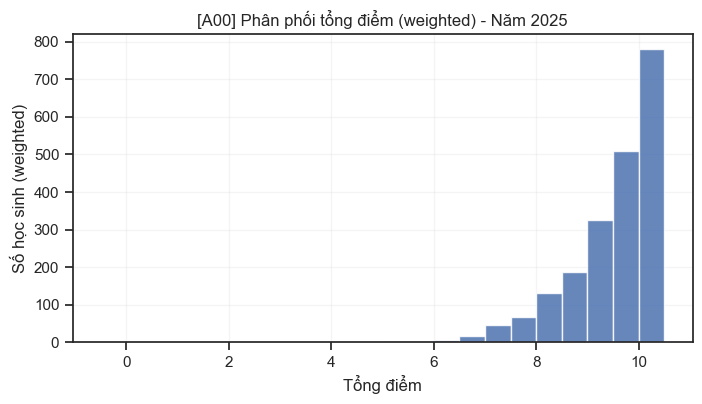

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


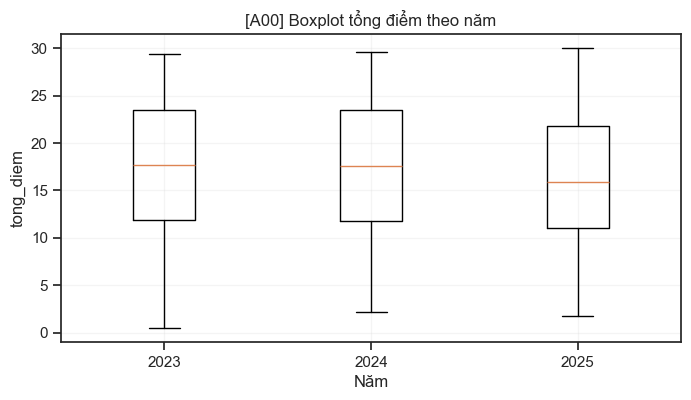

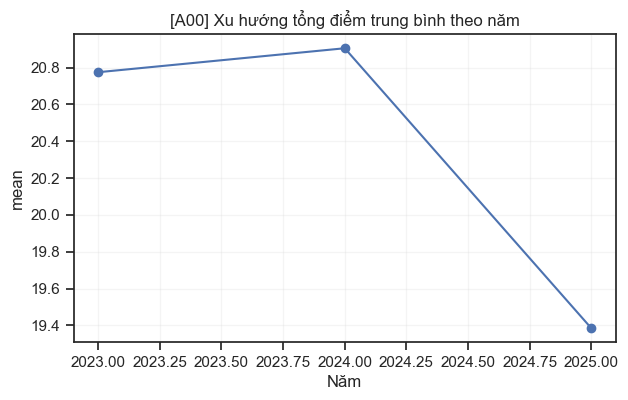


BLOCK: A01


,nam_hoc,mean,median,mode,std,min,max
0,2023,20.275288,20.45,20.5,3.339521,5.05,29.80
1,2024,20.473793,20.75,21.0,3.350473,5.20,29.60
2,2025,18.878852,18.85,20.0,3.627548,5.50,29.75


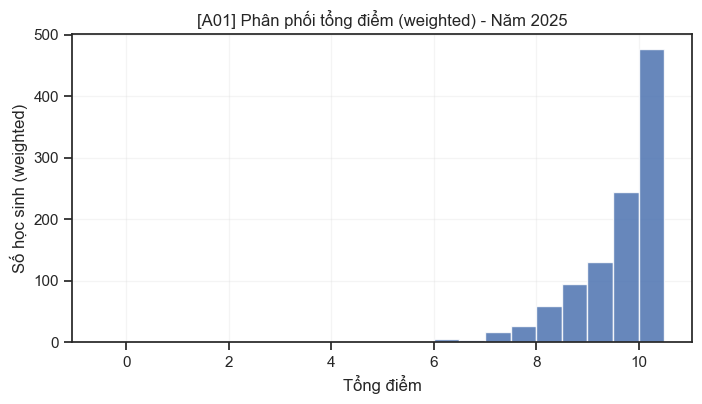

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


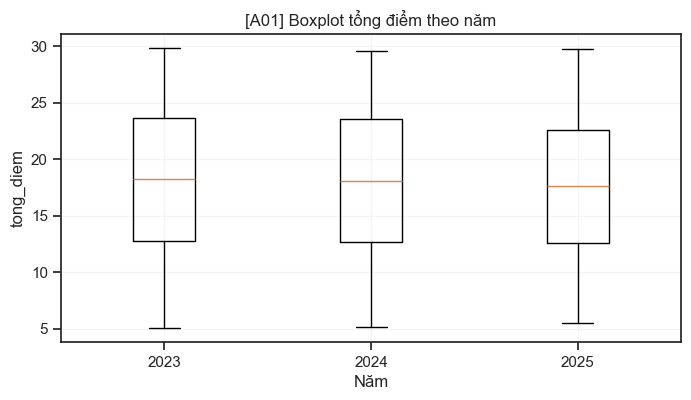

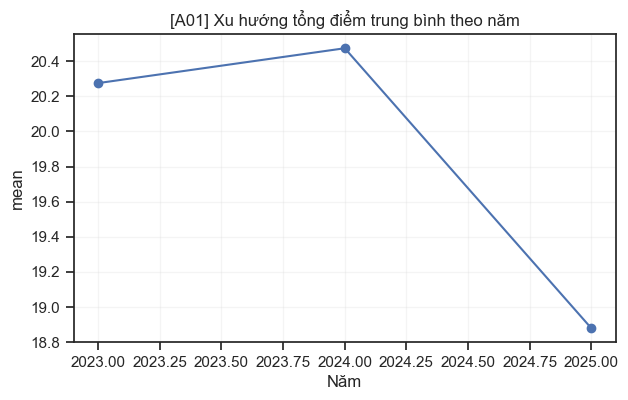


BLOCK: C00


,nam_hoc,mean,median,mode,std,min,max
0,2023,18.974926,19.00,18.75,3.378895,0.0,29.50
1,2024,20.952817,21.25,21.25,3.465673,0.0,29.75
2,2025,19.712084,19.85,23.25,4.291575,0.5,29.75


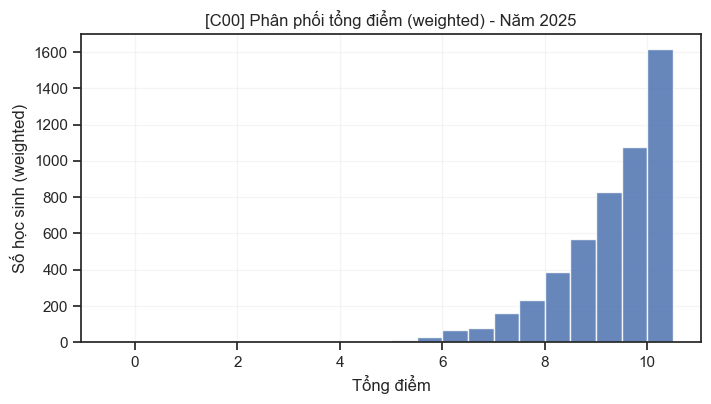

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


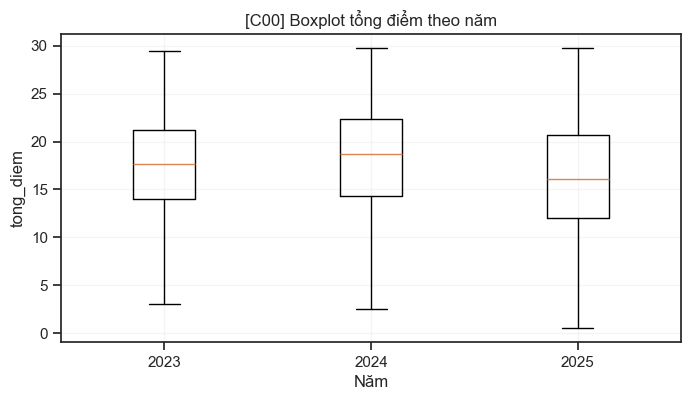

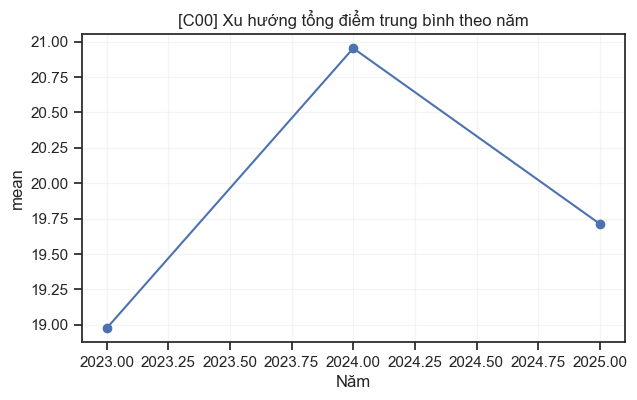


BLOCK: D01


,nam_hoc,mean,median,mode,std,min,max
0,2023,18.903006,19.05,19.60,3.818043,2.80,28.90
1,2024,19.509257,19.65,19.00,3.627499,3.85,28.75
2,2025,18.612844,18.50,19.25,2.959746,3.50,29.00


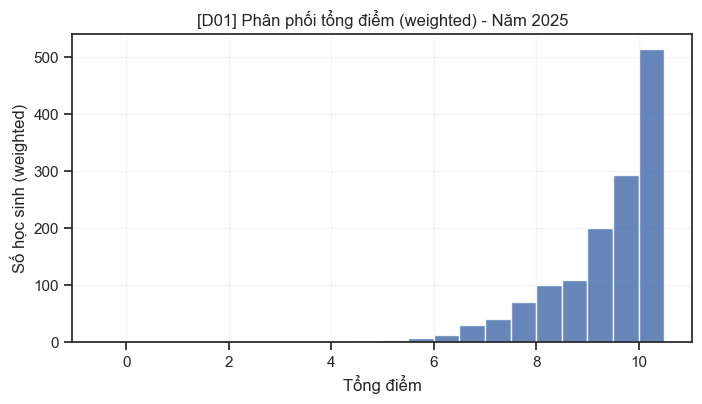

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


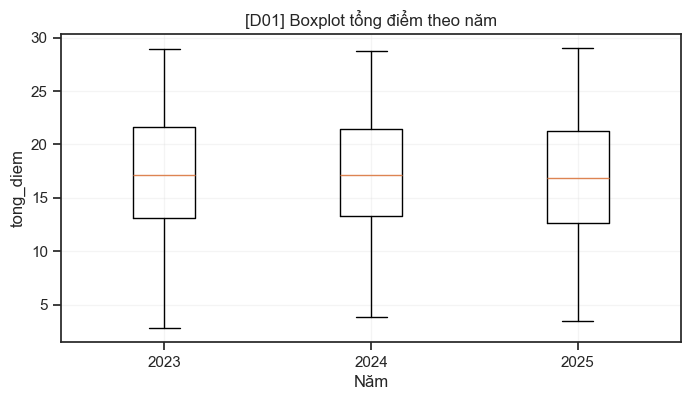

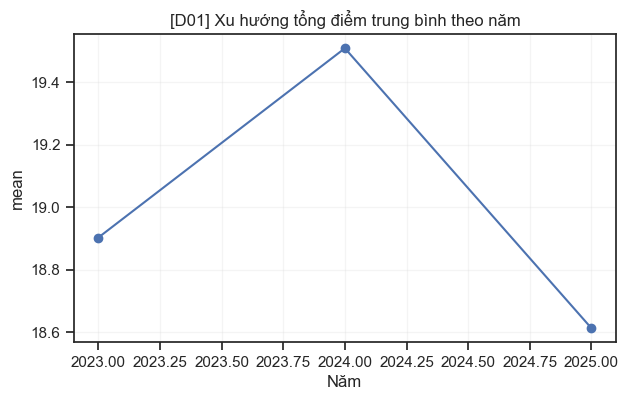

In [21]:
# ==== Cell 5: EDA theo KHỐI (A00, A01, C00, D01) ====
for blk in block_entities:
    try:
        dist = load_clean_csv("Block_Data", blk, "distribution")
        ana = load_clean_csv("Block_Data", blk, "analysis")
    except FileNotFoundError as e:
        print(f"⚠️ Skip {blk}:", e)
        continue

    print("\n" + "="*80)
    print(f"BLOCK: {blk}")
    display(ana)

    year_pick = int(sorted(dist["nam_hoc"].unique())[-1])
    dfy = dist[dist["nam_hoc"] == year_pick]
    plot_weighted_hist(dfy["tong_diem"].to_numpy(), dfy["so_hoc_sinh"].to_numpy(),
                      title=f"[{blk}] Phân phối tổng điểm (weighted) - Năm {year_pick}", xlabel="Tổng điểm")

    plot_box_by_year(dist, score_col="tong_diem", year_col="nam_hoc", title=f"[{blk}] Boxplot tổng điểm theo năm")

    if "mean" in ana.columns:
        plot_trend_mean(ana, year_col="nam_hoc", mean_col="mean", title=f"[{blk}] Xu hướng tổng điểm trung bình theo năm")



PROVINCE: TP.HCM (ThanhPhoHoChiMinh)


,nam_hoc,mean,median,mode,std,min,max
0,2023,38.174897,39.70,39.95,7.643105,0.45,55.4
1,2024,38.443969,39.85,40.05,7.700110,2.40,55.9
2,2025,25.010852,25.10,26.75,4.332279,0.00,48.0


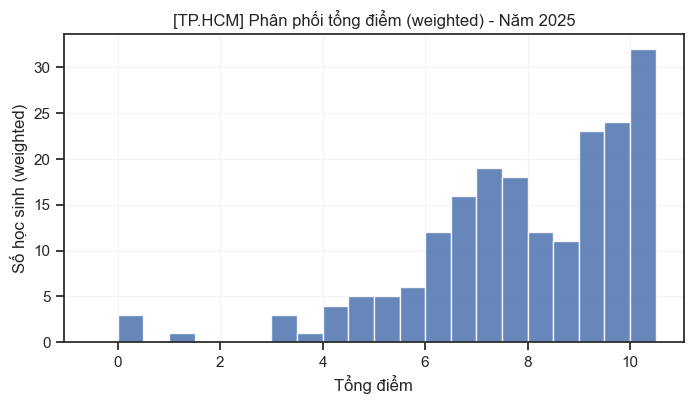

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


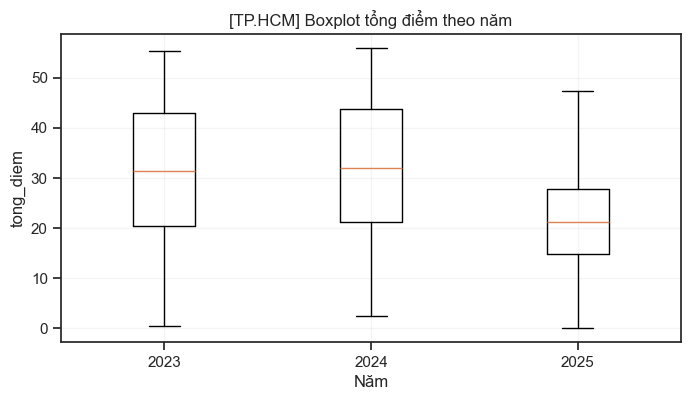

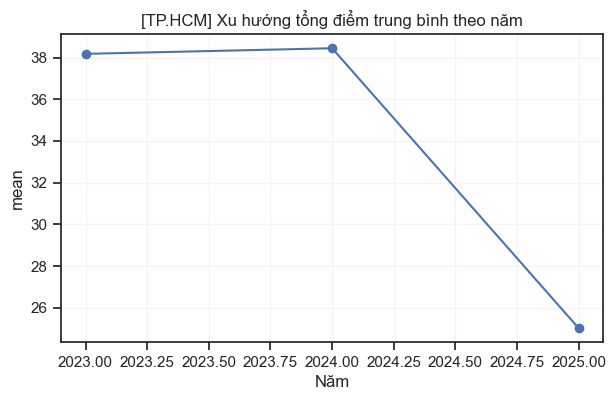


PROVINCE: Hà Nội (HaNoi)


,nam_hoc,mean,median,mode,std,min,max
0,2023,37.324483,39.20,41.00,9.029400,0.00,56.30
1,2024,39.081294,40.95,43.20,8.888627,1.75,57.85
2,2025,25.724696,26.10,28.75,4.820202,1.70,52.00


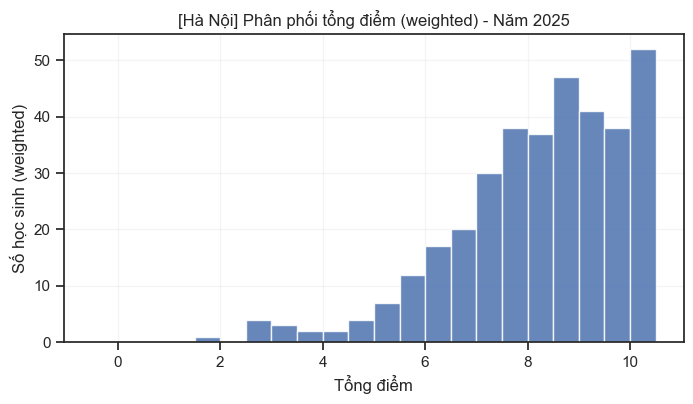

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


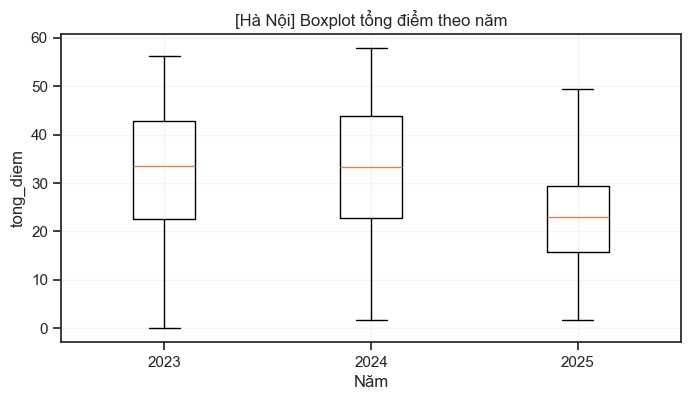

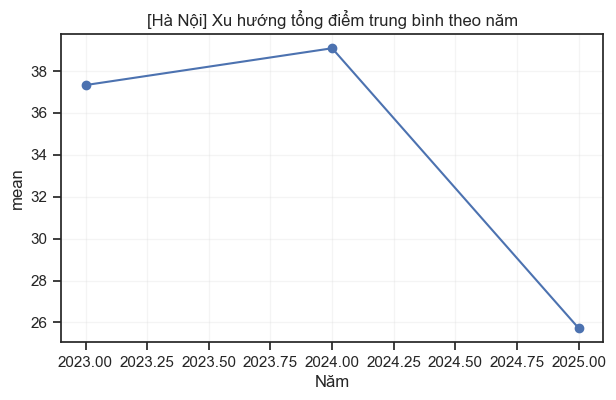

⚠️ Skip DaNang: Không tìm thấy file: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Clean_Data_2023-2025\Province_Data\CleanData_DaNang\Export_Distribution_DaNang.csv

PROVINCE: Cà Mau (CaMau)


,nam_hoc,mean,median,mode,std,min,max
0,2023,36.564900,37.05,36.9,6.432683,6.00,53.55
1,2024,37.232087,37.90,40.0,6.849761,6.25,55.30
2,2025,23.771190,23.85,25.5,4.225072,4.70,48.35


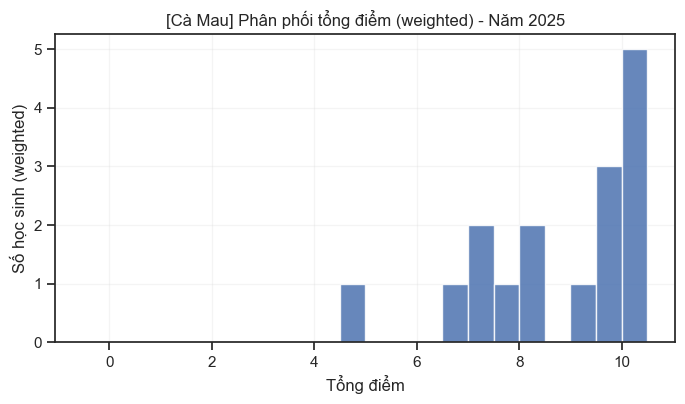

C:\Users\Admin\AppData\Local\Temp\ipykernel_6972\2239259398.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=years, showfliers=False)


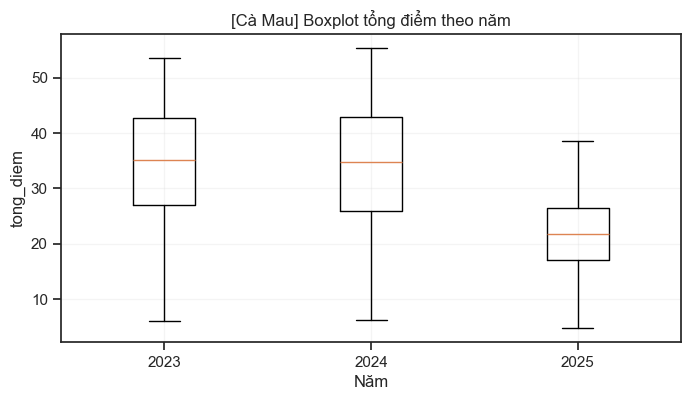

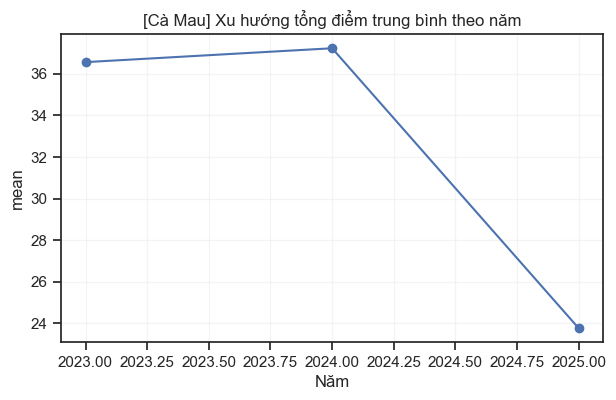

In [22]:
# ==== Cell 6: EDA theo TỈNH (TP.HCM, Hà Nội, Đà Nẵng, Cà Mau) ====
for prov in province_entities:
    try:
        dist = load_clean_csv("Province_Data", prov, "distribution")
        ana = load_clean_csv("Province_Data", prov, "analysis")
    except FileNotFoundError as e:
        print(f"⚠️ Skip {prov}:", e)
        continue

    label = province_labels.get(prov, prov)
    print("\n" + "="*80)
    print(f"PROVINCE: {label} ({prov})")
    display(ana)

    year_pick = int(sorted(dist["nam_hoc"].unique())[-1])
    dfy = dist[dist["nam_hoc"] == year_pick]
    plot_weighted_hist(dfy["tong_diem"].to_numpy(), dfy["so_hoc_sinh"].to_numpy(),
                      title=f"[{label}] Phân phối tổng điểm (weighted) - Năm {year_pick}", xlabel="Tổng điểm")

    plot_box_by_year(dist, score_col="tong_diem", year_col="nam_hoc", title=f"[{label}] Boxplot tổng điểm theo năm")

    if "mean" in ana.columns:
        plot_trend_mean(ana, year_col="nam_hoc", mean_col="mean", title=f"[{label}] Xu hướng tổng điểm trung bình theo năm")


**TODO (SSR/đồ thị bổ sung cho EDA):**
- [ ] SSR một vài đồ thị “đẹp” từ notebook EDA gốc (nếu cần)
- [ ] Bảng tổng hợp insight nhanh cho 3 nhóm (môn/khối/tỉnh)


## 5. Kiểm định ANOVA và t-test

Phần này dùng `Module/ANOVA_ttest.py` để kiểm định khác biệt:
- **Theo môn/khối:** khác biệt điểm giữa các năm (t-test hoặc ANOVA).
- **Theo tỉnh:** khác biệt giữa các tỉnh trong một năm (ANOVA, hoặc t-test 2 tỉnh).

> Mục tiêu: cung cấp bằng chứng định lượng bổ trợ cho các quan sát EDA.


### 5.1 Tham chiếu code: Kiểm định ANOVA/t-test

In [23]:
# ==== Cell 5.1: Code references — ANOVA_ttest ====
show_object(ANOVA_ttest)
# hoặc xem theo file:
# show_file("Module/ANOVA_ttest.py", start=1, end=260)


--- source: ANOVA_ttest (showing 220/653 lines) ---
class ANOVA_ttest:
    """Lớp để thực hiện phân tích điểm thi sử dụng 2 kiểm định ANOVA và T-test.

    Mô tả
    -----
    - Nhận dữ liệu từ các tệp .csv trong phần Clean_Data_2023-2025
      (thường là dạng Distribution đã đọc thành DataFrame).
    - Sử dụng kiểm định ANOVA và T-test để phân tích sự khác biệt điểm thi:
        * Giữa các năm cho một môn học / một khối.
        * Giữa các tỉnh trong một năm.
    - Kết quả trả về dưới dạng dict để dễ dàng theo dõi / log / chuyển thành DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        Dữ liệu điểm thi (thường là Distribution) đã đọc thành DataFrame.
        Cần có tối thiểu các cột:
            - group_col (mặc định 'nam_hoc'): cột phân nhóm (năm học).
            - score_col (ví dụ 'diem' hoặc 'tong_diem'): cột điểm.
            - 'so_hoc_sinh' : tần suất (số thí sinh đạt mức điểm đó).
        Tùy trường hợp có thêm:
            - 'mon_hoc'  : nếu phân tích nhi

In [24]:
# ==== Cell 7: ANOVA & t-test (minh hoạ) ====
results = []

# Subject: t-test 2024 vs 2025
for subj in subject_entities:
    try:
        dist = load_clean_csv("Subject_Data", subj, "distribution")
    except FileNotFoundError:
        continue
    tester = ANOVA_ttest(dist, group_col="nam_hoc", score_col="diem")
    years = set(dist["nam_hoc"].unique())
    if 2024 in years and 2025 in years:
        r = tester.t_test_subject_two_years(subject=subj, year1=2024, year2=2025)
        r["entity_type"] = "subject"
        r["entity"] = subj
        results.append(r)

# Block: t-test 2024 vs 2025
for blk in block_entities:
    try:
        dist = load_clean_csv("Block_Data", blk, "distribution")
    except FileNotFoundError:
        continue
    tester = ANOVA_ttest(dist, group_col="nam_hoc", score_col="tong_diem")
    years = set(dist["nam_hoc"].unique())
    if 2024 in years and 2025 in years:
        r = tester.t_test_block_two_years(block=blk, year1=2024, year2=2025)
        r["entity_type"] = "block"
        r["entity"] = blk
        results.append(r)

# Province: ANOVA year 2025 across selected provinces
prov_dfs = []
for prov in province_entities:
    try:
        prov_dfs.append(load_clean_csv("Province_Data", prov, "distribution"))
    except FileNotFoundError:
        pass

if len(prov_dfs) >= 3:
    prov_all = pd.concat(prov_dfs, ignore_index=True)
    tester_p = ANOVA_ttest(prov_all, group_col="nam_hoc", score_col="tong_diem")
    if 2025 in set(prov_all["nam_hoc"].unique()):
        r = tester_p.anova_province(year=2025)
        r["entity_type"] = "province_anova"
        r["entity"] = "selected_provinces"
        results.append(r)

res_df = pd.DataFrame(results)
display(res_df)


,subject,year1,year2,t_stat,p_value,p_value_text,one_tail,alternative,cohens_d,effect_strength,interpretation,entity_type,entity,block,year,num_provinces,F_statistic
0,toan,2024.0,2025.0,750.076433,1.000000e-16,< 1e-16,False,less,1.014493,Mạnh,Có sự khác biệt.,subject,toan,NaN,NaN,NaN,NaN
1,ngu_van,2024.0,2025.0,135.783310,1.000000e-16,< 1e-16,False,less,0.183617,Rất yếu,Có sự khác biệt.,subject,ngu_van,NaN,NaN,NaN,NaN
2,vat_li,2024.0,2025.0,-82.454518,1.000000e-16,< 1e-16,False,less,-0.197546,Rất yếu,Có sự khác biệt.,subject,vat_li,NaN,NaN,NaN,NaN
3,lich_su,2024.0,2025.0,19.020354,1.000000e-16,< 1e-16,False,less,0.035613,Rất yếu,Có sự khác biệt.,subject,lich_su,NaN,NaN,NaN,NaN
4,ngoai_ngu,2024.0,2025.0,36.607208,1.000000e-16,< 1e-16,False,less,0.068178,Rất yếu,Có sự khác biệt.,subject,ngoai_ngu,NaN,NaN,NaN,NaN
5,NaN,2024.0,2025.0,125.418960,1.000000e-16,< 1e-16,False,less,0.390974,Yếu,Có sự khác biệt.,block,A00,A00,NaN,NaN,NaN
6,NaN,2024.0,2025.0,144.163289,1.000000e-16,< 1e-16,False,less,0.456773,Yếu,Có sự khác biệt.,block,A01,A01,NaN,NaN,NaN
7,NaN,2024.0,2025.0,141.883683,1.000000e-16,< 1e-16,False,less,0.318092,Yếu,Có sự khác biệt.,block,C00,C00,NaN,NaN,NaN
8,NaN,2024.0,2025.0,143.919634,1.000000e-16,< 1e-16,False,less,0.270779,Yếu,Có sự khác biệt.,block,D01,D01,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,1.000000e-16,< 1e-16,NaN,NaN,NaN,NaN,Có khác biệt điểm giữa các tỉnh.,province_anova,selected_provinces,NaN,2025.0,3.0,1329.586461


## 6. Phân tích điểm gãy 2025 (Change Point)

Ta chuẩn bị chuỗi thời gian theo dạng `year, series_id, value`, sau đó detect và phân tích tác động pre/post.

**TODO (SSR/ảnh minh hoạ):**
- [ ] SSR kết quả detect điểm gãy từ notebook ChangePoint gốc (nếu cần)


### 6.1 Tham chiếu code: Change Point (Prepare → Detect → Analyze)

In [25]:
# ==== Cell 6.1: Code references — Change Point modules ====
show_object(ChangePointPreparer)
show_object(ChangePointDetector)
show_object(ChangePointAnalyzer)

# hoặc xem theo file:
# show_file("Model/ChangePointPreparer.py", start=1, end=240)


--- source: ChangePointPreparer (showing 57/57 lines) ---
class ChangePointPreparer:
    """
    Chuẩn bị dữ liệu cho bài toán Change Point Detection.
    """
    def __init__(self, clean_loader: CleanDataLoader):
        self.loader = clean_loader

    def _transform_to_timeseries(self, df: pd.DataFrame, series_id: str, metric: str = "mean") -> pd.DataFrame:
        if df is None or df.empty:
            return pd.DataFrame()
        
        # Kiểm tra cột metric
        if metric not in df.columns:
            # Fallback: lấy cột số đầu tiên không phải nam_hoc
            numeric_cols = df.select_dtypes(include=np.number).columns.difference(['nam_hoc'])
            if len(numeric_cols) > 0:
                metric = numeric_cols[0]
            else:
                return pd.DataFrame()
            
        df_out = df[["nam_hoc", metric]].copy()
        df_out.columns = ["year", "value"]
        df_out["series_id"] = series_id
        return df_out[["year", "series_id", "value"]].so

,year,series_id,value
0,2025,cn_cong_nghiep,5.792555
1,2025,cn_nong_nghiep,7.715897
2,2023,dia_li,6.147523
3,2024,dia_li,7.193541
4,2025,dia_li,6.642910


Series: 5 | points: 11
ChangePointDetector from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ChangePointDetector.py
ChangePointDetector signature: (data: pandas.core.frame.DataFrame, target_year: int = 2025, tolerance: int = 1)

▶️ Ruptures (PELT) ...


,series_id,algorithm,detected_years,hit_target,hit_year
0,dia_li,Ruptures_pelt,[2025],True,2025
1,gdcd,Ruptures_pelt,[2025],True,2025
2,hoa_hoc,Ruptures_pelt,[2025],True,2025



▶️ CUSUM ...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values
0,dia_li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2...."
1,gdcd,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]"
2,hoa_hoc,CUSUM_Mean,[2025],True,2025,"[0.8093976865838567, 1.4090177860160638, 0.0]"



▶️ Bayesian ...


,series_id,algorithm,detected_years,hit_target,hit_year,probability
0,dia_li,Bayesian_BOCPD,[2024],True,2024,1.0
1,gdcd,Bayesian_BOCPD,[2025],True,2025,1.0
2,hoa_hoc,Bayesian_BOCPD,[2025],True,2025,1.0



🏆 Tổng hợp hit_target 2025 (analyze_all) ...


,series_id,algorithm,detected_years,hit_target,hit_year,cusum_values,probability
0,dia_li,Ruptures_pelt,[2025],True,2025,NaN,NaN
1,gdcd,Ruptures_pelt,[2025],True,2025,NaN,NaN
2,hoa_hoc,Ruptures_pelt,[2025],True,2025,NaN,NaN
3,dia_li,CUSUM_Mean,[2024],True,2024,"[-1.2026252060996623, 0.04310144105559366, -2....",NaN
4,gdcd,CUSUM_Mean,[2025],True,2025,"[0.9451508856964479, 1.3836283241072733, 0.0]",NaN



ChangePointAnalyzer from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ChangePointAnalyzer.py
ChangePointAnalyzer signature: (data: pandas.core.frame.DataFrame, target_year: int = 2025)


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,series_id,break_point,mean_pre,mean_post,delta_pct,p_value,significant,cohen_d,magnitude
0,dia_li,2025,6.67,6.64,-0.41,0.9664,False,-0.04,Không đáng kể
1,gdcd,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)
2,hoa_hoc,2025,6.71,6.07,-9.58,0.0316,True,-14.25,Mạnh (Strong)
3,dia_li,2024,6.15,6.92,12.54,NaN,False,0.00,Không đáng kể
4,gdcd,2025,8.22,7.69,-6.44,0.0773,False,-5.79,Mạnh (Strong)


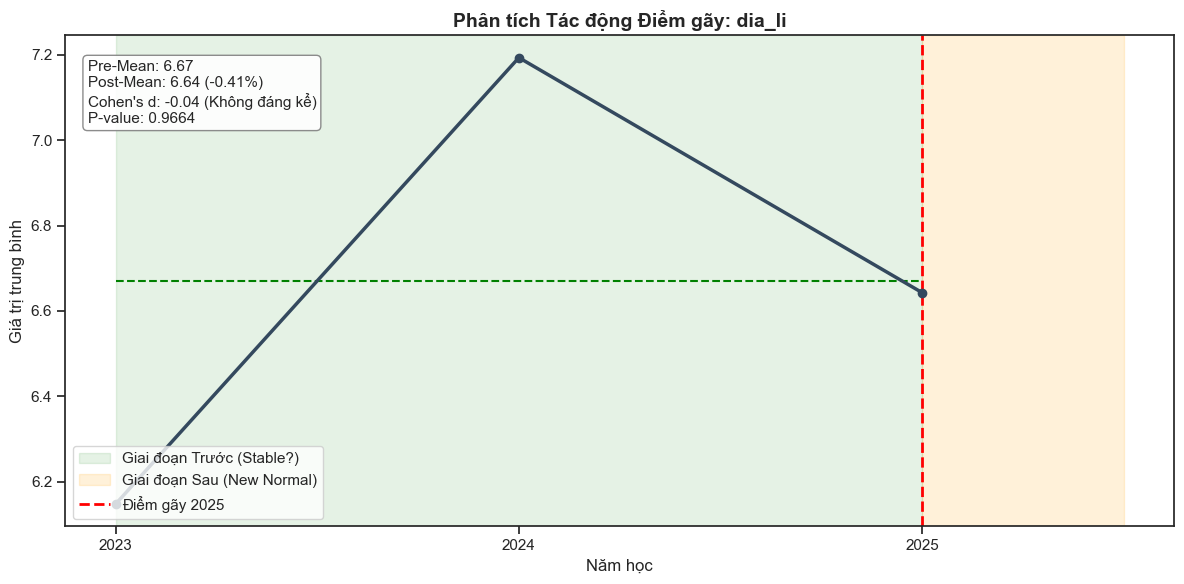

In [26]:
# ==== Cell 8: Change Point - Prepare + Detect + Analyze (theo đúng API trong project) ====
from pathlib import Path
import inspect

# --- (0) Ensure PROJECT_ROOT đúng repo ---
if not (Path(PROJECT_ROOT) / "Clean_Data_2023-2025").exists():
    if (Path.cwd() / "Clean_Data_2023-2025").exists():
        PROJECT_ROOT = Path.cwd()
    else:
        raise FileNotFoundError(
            "Không tìm thấy Clean_Data_2023-2025. "
            f"PROJECT_ROOT hiện tại: {PROJECT_ROOT}"
        )

clean_root = Path(PROJECT_ROOT) / "Clean_Data_2023-2025"

# --- (1) Build time-series ---
loader_clean = CleanDataLoader(project_root=str(PROJECT_ROOT))
cprep = ChangePointPreparer(clean_loader=loader_clean)

domain = "subject"   # "block" | "province" | "subject"
metric = "mean"      # 'mean' | 'median' | ...

if domain == "subject":
    items = demo_subjects if ('demo_subjects' in globals() and demo_subjects) else list_entities(clean_root / "Subject_Data")[:5]
    ts_df = cprep.get_subject_series(items, metric=metric)
elif domain == "block":
    items = demo_blocks if ('demo_blocks' in globals() and demo_blocks) else list_entities(clean_root / "Block_Data")[:5]
    ts_df = cprep.get_block_series(items, metric=metric)
else:
    items = demo_provinces if ('demo_provinces' in globals() and demo_provinces) else list_entities(clean_root / "Province_Data")[:5]
    ts_df = cprep.get_province_series(items, metric=metric)

ts_df = ts_df.dropna(subset=["year", "series_id", "value"]).copy()
ts_df["year"] = ts_df["year"].astype(int)
ts_df = ts_df.sort_values(["series_id", "year"]).reset_index(drop=True)

display(ts_df.head())
print("Series:", ts_df["series_id"].nunique(), "| points:", len(ts_df))

# --- (2) Detect theo đúng ChangePointDetector của bạn ---
print("ChangePointDetector from:", inspect.getfile(ChangePointDetector))
print("ChangePointDetector signature:", inspect.signature(ChangePointDetector))

detector = ChangePointDetector(ts_df, target_year=2025, tolerance=1)

print("\n▶️ Ruptures (PELT) ...")
df_pelt = detector.detect_ruptures(method="pelt", model="l2", pen=1)
display(df_pelt.head())

print("\n▶️ CUSUM ...")
df_cusum = detector.detect_cusum()
display(df_cusum.head())

print("\n▶️ Bayesian ...")
df_bayes = detector.detect_bayesian(probability_threshold=0.01)
display(df_bayes.head())

print("\n🏆 Tổng hợp hit_target 2025 (analyze_all) ...")
cp_df = detector.analyze_all()
display(cp_df.head())

# --- (3) Analyze impact: ChangePointAnalyzer dùng analyze_impact(cp_df), KHÔNG có analyze_all() ---
print("\nChangePointAnalyzer from:", inspect.getfile(ChangePointAnalyzer))
print("ChangePointAnalyzer signature:", inspect.signature(ChangePointAnalyzer))

analyzer = ChangePointAnalyzer(ts_df, target_year=2025)
impact_df = analyzer.analyze_impact(cp_df)   
display(impact_df.head())

if len(impact_df) > 0:
    demo_series = impact_df.iloc[0]["series_id"]
    analyzer.plot_impact_visual(demo_series)


## 7. Dự báo 2026

Gồm 2 nhánh:
- Theo môn: ForecastModel (ARIMA/RF/XGB)
- Theo khối: ForecastBlockModel (so sánh 3 model, chọn top-2 để dự báo)


### 7.1 Tham chiếu code: Forecast 2026 (theo môn / theo khối)

In [27]:
# ==== Cell 7.1: Code references — Forecast models ====
show_object(ForecastModel)
show_object(ForecastBlockModel)
show_object(build_ml_df)
# hoặc xem theo file:
# show_file("Model/ForecastSubjectModel.py", start=1, end=260)


--- source: ForecastModel (showing 64/64 lines) ---
class ForecastModel:
    """
    Lớp bao toàn bộ các model dự báo điểm trung bình theo môn (ARIMA, RF, XGB).

    Workflow (tương đương notebook Forecast.ipynb phần 3.1):
        fm = ForecastModel(df_ml)
        arima_res = fm.evaluate_arima(scenario="raw")
        rf_res    = fm.evaluate_rf(scenario="raw")
        xgb_res   = fm.evaluate_xgb(scenario="post")
        df_forecast_2026 = fm.forecast_2026_xgb(alpha=0.05, scenario="post")
    """

    __slots__ = (
        "df_ml",
        "year_for_test",
        "arima",
        "rf",
        "xgb",
    )

    def __init__(self, df_ml: pd.DataFrame):
        self.df_ml = df_ml.copy()
        self.df_ml["year"] = self.df_ml["year"].astype(int)
        self.year_for_test = int(self.df_ml["year"].max())

        # Khởi tạo các model đúng như trong Forecast.ipynb
        self.arima = ArimaSubjectModel(min_points_for_ar1=4)
        self.rf = RFGlobalModel()
        self.xgb = XGBGlobalModel

In [28]:
# ==== Cell 9: Forecast theo MÔN (đúng API project) ====
import pandas as pd
from pathlib import Path
import inspect

RUN_FORECAST_SUBJECT = True

if RUN_FORECAST_SUBJECT:
    print("build_ml_df from:", inspect.getfile(build_ml_df))
    print("build_ml_df signature:", inspect.signature(build_ml_df))

    # 1) Load bảng thống kê theo môn-năm từ Clean_Data_2023-2025 (Export_Analysis_*.csv)
    SUBJECTS_FORECAST = ["toan", "ngu_van", "vat_li", "lich_su", "ngoai_ngu"]  # Toán, Văn, Lí, Sử, Anh

    subject_rows = []
    for sub in SUBJECTS_FORECAST:
        p = Path(clean_root) / "Subject_Data" / f"CleanData_{sub}" / f"Export_Analysis_{sub}.csv"
        if not p.exists():
            raise FileNotFoundError(f"Không tìm thấy file subject analysis: {p}")

        df_sub = pd.read_csv(p)

        # Chuẩn hoá cột về format build_ml_df cần: ['year','subject','mean_score', ...]
        # Export.py đang xuất 'nam_hoc' + 'mean' ...
        df_sub = df_sub.rename(columns={"nam_hoc": "year", "mean": "mean_score"}).copy()
        df_sub["year"] = df_sub["year"].astype(int)
        df_sub["subject"] = sub

        # chỉ lấy các cột cần thiết (có thể giữ thêm median/std nếu muốn)
        keep = ["year", "subject", "mean_score"]
        df_sub = df_sub[keep]

        subject_rows.append(df_sub)

    df_subject_stats = pd.concat(subject_rows, ignore_index=True).sort_values(["subject", "year"])
    display(df_subject_stats)

    # 2) Build ML features (post_2025, delta_score, mean_prev, ...)
    df_ml = build_ml_df(df_subject_stats)  # ✅ đúng: truyền df vào
    display(df_ml.head())

    # 3) Evaluate + Forecast theo đúng ForecastModel của project
    fmodel = ForecastModel(df_ml)

    arima_res = fmodel.evaluate_arima(scenario="raw")   # ARIMA theo từng môn
    rf_res    = fmodel.evaluate_rf(scenario="raw")      # RF global
    xgb_res   = fmodel.evaluate_xgb(scenario="post")    # XGB global (có post_2025)

    print("\n=== Evaluation: ARIMA ===")
    display(arima_res)
    print("\n=== Evaluation: RF ===")
    display(rf_res)
    print("\n=== Evaluation: XGB ===")
    display(xgb_res)

    # Forecast 2026 (XGB + CI)
    forecast_2026 = fmodel.forecast_2026_xgb(alpha=0.05, scenario="post")
    print("\n=== Forecast 2026 (XGB + CI) ===")
    display(forecast_2026)


build_ml_df from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ForecastSubjectModel.py
build_ml_df signature: (df: 'pd.DataFrame', df_rates: 'Optional[pd.DataFrame]' = None) -> 'pd.DataFrame'


,year,subject,mean_score
9,2023,lich_su,6.025629
10,2024,lich_su,6.570343
11,2025,lich_su,6.514921
12,2023,ngoai_ngu,5.462410
13,2024,ngoai_ngu,5.521938
14,2025,ngoai_ngu,5.406338
3,2023,ngu_van,6.858194
4,2024,ngu_van,7.231146
5,2025,ngu_van,6.990479
0,2023,toan,6.250557


,year,subject,mean_score,post_2025,delta_score,mean_prev,is_first_year
9,2023,lich_su,6.025629,0,0.000000,0.000000,1
10,2024,lich_su,6.570343,0,0.544714,6.025629,0
11,2025,lich_su,6.514921,1,-0.055422,6.297986,0
12,2023,ngoai_ngu,5.462410,0,0.000000,0.000000,1
13,2024,ngoai_ngu,5.521938,0,0.059528,5.462410,0


[ARIMA 5 subject] MAE (2025) = 0.4529
[RF-global-raw 5 subject] MAE (2025) = 0.4761
[XGB-global-post 5 subject] MAE (2025) = 0.4715

=== Evaluation: ARIMA ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
0,lich_su,6.514921,6.297981,0.216940,0.216940,3.329893
1,ngoai_ngu,5.406338,5.492169,0.085832,0.085832,1.587614
2,ngu_van,6.990479,7.044665,0.054186,0.054186,0.775143
3,toan,4.799712,6.348928,1.549216,1.549216,32.277275
4,vat_li,6.978461,6.620378,0.358082,0.358082,5.131249



=== Evaluation: RF ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
11,lich_su,6.514921,6.453805,0.061116,0.061116,0.938097
14,ngoai_ngu,5.406338,5.647305,0.240967,0.240967,4.457127
5,ngu_van,6.990479,7.063789,0.073310,0.073310,1.048710
2,toan,4.799712,6.454714,1.655002,1.655002,34.481271
8,vat_li,6.978461,6.628139,0.350321,0.350321,5.020040



=== Evaluation: XGB ===


,subject,mean_true,mean_pred,MAE,RMSE,MAPE
11,lich_su,6.514921,6.566544,0.051623,0.051623,0.792377
14,ngoai_ngu,5.406338,5.525697,0.119359,0.119359,2.207763
5,ngu_van,6.990479,7.222892,0.232413,0.232413,3.324711
2,toan,4.799712,6.449338,1.649626,1.649626,34.369275
8,vat_li,6.978461,6.673825,0.304635,0.304635,4.365365


[XGB-global-post 5 subject] MAE (2025) = 0.2540
[XGB-global-post 5 subject] MAE (2025) = 0.4715

=== Forecast 2026 (XGB + CI) ===


,subject,year,mean_actual,mean_predicted,lower_CI,upper_CI
0,lich_su,2024,6.570343,6.025900,5.625963,6.425837
1,lich_su,2025,6.514921,6.566544,5.088873,8.044214
2,ngoai_ngu,2024,5.521938,5.463560,5.063623,5.863497
3,ngoai_ngu,2025,5.406338,5.525697,4.048026,7.003367
4,ngu_van,2024,7.231146,6.854883,6.454947,7.254820
5,ngu_van,2025,6.990479,7.222892,5.745222,8.700562
6,toan,2024,6.447309,6.250014,5.850078,6.649951
7,toan,2025,4.799712,6.449338,4.971668,7.927009
8,vat_li,2024,6.666866,6.573370,6.173434,6.973307
9,vat_li,2025,6.978461,6.673825,5.196155,8.151496


In [29]:
# ==== Cell 10: Forecast theo KHỐI (đúng pipeline Export của project) ====
import pandas as pd
from pathlib import Path
import inspect

RUN_FORECAST_BLOCK = True

if RUN_FORECAST_BLOCK:
    print("ForecastBlockModel from:", inspect.getfile(ForecastBlockModel))
    print("ForecastBlockModel signature:", inspect.signature(ForecastBlockModel))

    # (1) Load tổng học sinh theo năm
    yearly_path = Path(clean_root) / "Export_Yearly_Total_Students.csv"
    if not yearly_path.exists():
        raise FileNotFoundError(f"Không tìm thấy: {yearly_path}")

    df_yearly = pd.read_csv(yearly_path).copy()
    df_yearly["nam_hoc"] = pd.to_numeric(df_yearly["nam_hoc"], errors="coerce")
    df_yearly = df_yearly.dropna(subset=["nam_hoc"]).copy()
    df_yearly["nam_hoc"] = df_yearly["nam_hoc"].astype(int)

    # tìm cột tổng học sinh (tên có thể khác nhau)
    total_candidates = [c for c in df_yearly.columns if c != "nam_hoc"]
    if not total_candidates:
        raise ValueError("Export_Yearly_Total_Students.csv không có cột tổng học sinh ngoài 'nam_hoc'.")

    # chọn cột numeric đầu tiên
    total_col = None
    for c in total_candidates:
        s = pd.to_numeric(df_yearly[c], errors="coerce")
        if s.notna().sum() > 0:
            total_col = c
            df_yearly[c] = s
            break
    if total_col is None:
        raise ValueError("Không xác định được cột tổng học sinh (numeric) trong Export_Yearly_Total_Students.csv.")

    df_yearly = df_yearly.rename(columns={total_col: "total_students_year"})[["nam_hoc", "total_students_year"]]
    display(df_yearly)

    # (2) Build df_block_features = stats (analysis) + n_students (từ distribution) + total_students_year
    TOP_BLOCKS = ["A00", "A01", "B00", "C00", "D01", "D07", "D08", "D09", "A02", "A03"]  # đúng default model
    block_root = Path(clean_root) / "Block_Data"

    rows = []
    for blk in TOP_BLOCKS:
        p_stats = block_root / f"CleanData_{blk}" / f"Export_Analysis_{blk}.csv"
        p_dist  = block_root / f"CleanData_{blk}" / f"Export_Distribution_{blk}.csv"

        if not p_stats.exists() or not p_dist.exists():
            # thiếu file thì bỏ qua để report vẫn chạy
            continue

        df_stats = pd.read_csv(p_stats).copy()
        df_dist  = pd.read_csv(p_dist).copy()

        # chuẩn hoá 'nam_hoc'
        df_stats["nam_hoc"] = pd.to_numeric(df_stats["nam_hoc"], errors="coerce")
        df_stats = df_stats.dropna(subset=["nam_hoc"]).copy()
        df_stats["nam_hoc"] = df_stats["nam_hoc"].astype(int)

        df_dist["nam_hoc"] = pd.to_numeric(df_dist["nam_hoc"], errors="coerce")
        df_dist = df_dist.dropna(subset=["nam_hoc"]).copy()
        df_dist["nam_hoc"] = df_dist["nam_hoc"].astype(int)

        # tìm cột đếm học sinh trong distribution
        count_col = None
        for c in ["so_hoc_sinh", "n_students", "count", "num_students", "n"]:
            if c in df_dist.columns:
                count_col = c
                break
        if count_col is None:
            raise ValueError(f"Distribution của {blk} không có cột đếm học sinh. File: {p_dist}")

        df_dist[count_col] = pd.to_numeric(df_dist[count_col], errors="coerce").fillna(0)

        # n_students theo năm = sum(so_hoc_sinh) theo nam_hoc
        df_n = df_dist.groupby("nam_hoc", as_index=False)[count_col].sum().rename(columns={count_col: "n_students"})

        # merge: stats + n_students + total_students_year
        df_blk = df_stats.merge(df_n, on="nam_hoc", how="left").merge(df_yearly, on="nam_hoc", how="left")
        df_blk["khoi"] = blk

        rows.append(df_blk)

    if not rows:
        raise ValueError("Không tạo được df_block_features (thiếu file analysis/distribution của các khối TOP_BLOCKS).")

    df_block_features = pd.concat(rows, ignore_index=True)
    display(df_block_features.head())
    print("Blocks loaded:", df_block_features["khoi"].nunique(), "| rows:", len(df_block_features))

    # (3) Forecast bằng đúng API ForecastBlockModel
    fb = ForecastBlockModel(df_block_features, year_test=2025, top_blocks=TOP_BLOCKS)

    comp_df = fb.compare_models_2025()
    print("\n=== Compare models on year 2025 ===")
    display(comp_df)

    out_df = fb.forecast_2026()
    print("\n=== Forecast shares (2023–2026) ===")
    display(out_df)

    # (4) Hiển thị đúng 4 khối cậu yêu cầu trong report
    BLOCKS_SHOW = ["A00", "A01", "C00", "D01"]
    if "khoi" in out_df.columns:
        print("\n=== Subset (A00, A01, C00, D01) ===")
        display(out_df[out_df["khoi"].isin(BLOCKS_SHOW)].reset_index(drop=True))


ForecastBlockModel from: C:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject\Model\ForecastBlockModel.py
ForecastBlockModel signature: (df_block_features: 'pd.DataFrame', year_test: 'int' = 2025, top_blocks: 'Optional[Sequence[str]]' = None)


,nam_hoc,total_students_year
0,2023,1017584
1,2024,1061604
2,2025,1153072


,nam_hoc,mean,median,mode,std,min,max,n_students,total_students_year,khoi
0,2023,20.774499,21.15,22.1,3.094093,0.45,29.35,325902,1017584,A00
1,2024,20.904633,21.30,22.8,3.380354,2.15,29.60,343800,1061604,A00
2,2025,19.384368,19.25,22.0,4.337350,1.70,30.00,165467,1153072,A00
3,2023,20.275288,20.45,20.5,3.339521,5.05,29.80,315146,1017584,A01
4,2024,20.473793,20.75,21.0,3.350473,5.20,29.60,329761,1061604,A01


Blocks loaded: 10 | rows: 28

🔎 So sánh MAE năm 2025 giữa các model:
                 model_display  MAE_2025
0                  ARIMA share  0.046845
1         Linear-GD (baseline)  0.052721
2  Multi-REG (Ridge + softmax)  0.076309
👉 Top-2 model dùng cho forecast 2026: ['ARIMA', 'MultiShareReg']

=== Compare models on year 2025 ===


,model_id,model_display,MAE_2025
0,ARIMA,ARIMA share,0.046845
1,LinearGD,Linear-GD (baseline),0.052721
2,MultiShareReg,Multi-REG (Ridge + softmax),0.076309



Bảng share 2026 (final):
    nam_hoc khoi     share
3      2026  A00  0.085476
7      2026  A01  0.083757
11     2026  A02  0.083543
13     2026  A03  0.053383
17     2026  B00  0.084203
21     2026  C00  0.124623
25     2026  D01  0.146800
29     2026  D07  0.147168
33     2026  D08  0.082189
37     2026  D09  0.108858

=== Forecast shares (2023–2026) ===


,nam_hoc,khoi,share
0,2023,A00,0.070797
1,2024,A00,0.071852
2,2025,A00,0.110738
3,2026,A00,0.085476
4,2023,A01,0.068460
5,2024,A01,0.068918
6,2025,A01,0.099671
7,2026,A01,0.083757
8,2023,A02,0.070066
9,2024,A02,0.071016



=== Subset (A00, A01, C00, D01) ===


,nam_hoc,khoi,share
0,2023,A00,0.070797
1,2024,A00,0.071852
2,2025,A00,0.110738
3,2026,A00,0.085476
4,2023,A01,0.068460
5,2024,A01,0.068918
6,2025,A01,0.099671
7,2026,A01,0.083757
8,2023,C00,0.148093
9,2024,C00,0.147133


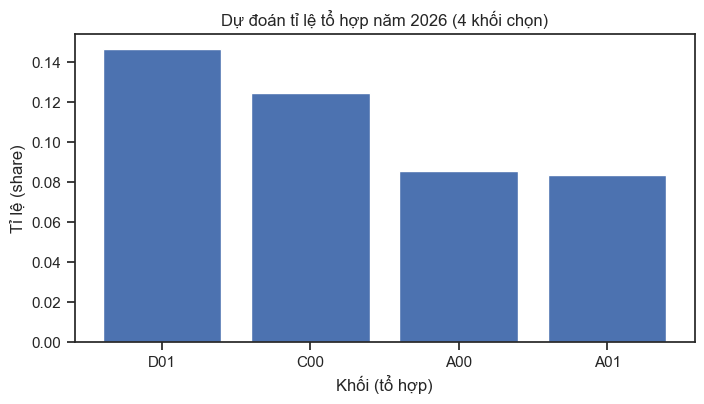

,nam_hoc,khoi,share
0,2026,D01,0.146800
1,2026,C00,0.124623
2,2026,A00,0.085476
3,2026,A01,0.083757


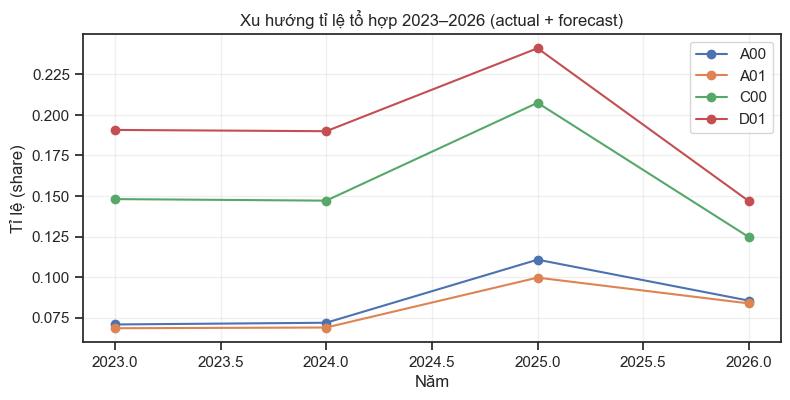


[TODO] Chèn SSR/ảnh minh hoạ bổ sung: ví dụ biểu đồ từ dashboard hoặc screenshot bảng dự đoán.


In [30]:
# ==== Cell 11: Trực quan hoá dự đoán tỉ lệ tổ hợp (Block share forecast) ====
import pandas as pd
import matplotlib.pyplot as plt

# out_df phải có từ Cell 10
required_cols = {"khoi"}
if not required_cols.issubset(set(out_df.columns)):
    raise ValueError(f"out_df thiếu cột bắt buộc: {required_cols - set(out_df.columns)}")

# tìm cột năm & cột share (tên có thể khác nhau theo implementation)
year_col = None
for c in ["nam_hoc", "year"]:
    if c in out_df.columns:
        year_col = c
        break
if year_col is None:
    raise ValueError("out_df không có cột năm (nam_hoc/year).")

share_col = None
for c in ["share", "share_in_year", "pred_share", "forecast_share"]:
    if c in out_df.columns:
        share_col = c
        break
if share_col is None:
    # fallback: chọn cột numeric hợp lý nhất (không phải year)
    numeric_cols = [c for c in out_df.columns if c != year_col and pd.api.types.is_numeric_dtype(out_df[c])]
    if not numeric_cols:
        raise ValueError("Không tìm thấy cột share trong out_df.")
    share_col = numeric_cols[0]

BLOCKS_SHOW = ["A00", "A01", "C00", "D01"]
df_plot = out_df[out_df["khoi"].isin(BLOCKS_SHOW)].copy()

df_plot[year_col] = pd.to_numeric(df_plot[year_col], errors="coerce")
df_plot = df_plot.dropna(subset=[year_col]).copy()
df_plot[year_col] = df_plot[year_col].astype(int)
df_plot[share_col] = pd.to_numeric(df_plot[share_col], errors="coerce")

# --- (1) Bar chart: share năm 2026 ---
df_2026 = df_plot[df_plot[year_col] == 2026].sort_values(share_col, ascending=False)
if df_2026.empty:
    print("⚠️ Không có dòng năm 2026 trong out_df. Kiểm tra forecast_2026() có tạo year=2026 không.")
else:
    plt.figure(figsize=(8, 4))
    plt.bar(df_2026["khoi"], df_2026[share_col])
    plt.title("Dự đoán tỉ lệ tổ hợp năm 2026 (4 khối chọn)")
    plt.xlabel("Khối (tổ hợp)")
    plt.ylabel("Tỉ lệ (share)")
    plt.xticks(rotation=0)
    plt.show()

    display(df_2026[[year_col, "khoi", share_col]].reset_index(drop=True))

# --- (2) Line chart: trend 2023–2026 ---
plt.figure(figsize=(9, 4))
for blk in BLOCKS_SHOW:
    tmp = df_plot[df_plot["khoi"] == blk].sort_values(year_col)
    plt.plot(tmp[year_col], tmp[share_col], marker="o", label=blk)

plt.title("Xu hướng tỉ lệ tổ hợp 2023–2026 (actual + forecast)")
plt.xlabel("Năm")
plt.ylabel("Tỉ lệ (share)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- (3) Markdown placeholder cho SSR/ảnh minh hoạ thêm ---
print("\n[TODO] Chèn SSR/ảnh minh hoạ bổ sung: ví dụ biểu đồ từ dashboard hoặc screenshot bảng dự đoán.")


## 8. Kết luận, hạn chế và hướng phát triển

**Kết luận (TODO):**
- [ ] Tóm tắt EDA (môn/khối/tỉnh)
- [ ] Tóm tắt kiểm định (ANOVA/t-test)
- [ ] Tóm tắt change point 2025
- [ ] Tóm tắt forecast 2026 (môn + khối)

**Hạn chế (TODO):**
- [ ] Chuỗi thời gian ngắn (2023–2025)
- [ ] 2025 là mốc thay đổi mạnh → rủi ro khi extrapolate

**Hướng phát triển (TODO):**
- [ ] Mở rộng dữ liệu nhiều năm hơn (nếu có)
- [ ] Bổ sung đánh giá độ tin cậy (CI) chặt chẽ hơn
